# Решающее дерево

### Примечание
### #
Данная лабораторная работа не относится напрямую к изучению питона в целом или какого то конкретного модуля. Задача взята из курса по машинному обучению.
Здесь я хочу проверить ваши умения разбираться в предлагаемом алгоритме и навыки в реализации этих алгоритмов.
Проведем эксперимент и посмотрим на результат. Если будут возникать непреодолимые трудности, то просьба не прибегать к копированию решений из интернета, а обртиться за помощью к коллегам либо преподавателю.
### #

Отметим, что решающее дерево состоит из вершин, в которых записывает некоторое условие, а в листах дерева - прогноз. Условия во внутренних вершинах выбираются простыми. Наиболее частый вариант - проверка лежит ли значение некоторого признака $x^j$ левее порога $t$:

$[x^j \leq t]$

Легко заметить, что такое условие зависит только от одного признака. Прогноз в листе является вещественным числом, если решается задача регрессии. Если же решается задача классификации, то в качестве прогноза выступает или класс или распределение вероятностей классов.

Запишем некоторую функцию ошибки следующим образом: есть набор данных $X_m$, есть номер рассматриваемого признака $j$ и есть порог $t$.

$L(X_m, j, t) \rightarrow \underset{j,t}{min}$

Осуществим перебор всех возможных признаков $j$ и порогов $t$ для этих признаков. Каждый раз исходное множество будет разбиваться на два подмножества:

$X_l = \{x \in X_m | [ x^j \leq t ] \}$ и $X_к = \{x \in X_m | [ x^j > t ] \}$

Такую процедуру можно продолжить для каждого получившегося множества (рекурсивно вызывать функцию деления для получающихся подмножеств).

Необходимо отметить, что если вершина была объявлена листом, необходимо сделать прогноз для этого листа. Для задачи регрессии берется среднее значение по этой выборке,
для задачи классификации возвращается тот класс, которые наиболее популярен в выборке. Можно указывать вероятность классов в листе.

Для каждого разбиения необходимо расчитывать функцию потерь:

$L(X_m, j, t) = \frac{|X_l|}{|X_m|}H(X_l) + \frac{|X_r|}{|X_m|}H(X_r)$,

где $H(X)=\sum\limits_{k=1}^{K} p_k(1 - p_k)$ - критерий информативности Джинни.

$p_k$ - доля объектов класса $k$ в выборке X:

$p_k=\frac{1}{|X|}\sum\limits_{i \in X}{[y_i = k]}$

В задаче работаем только с числовыми данными и строим дерево классификации.

Данные сгенерированы случайным образом.

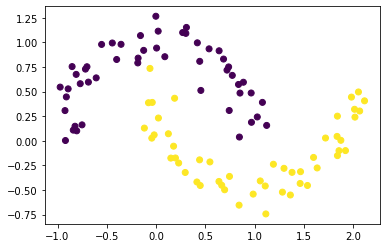

In [232]:
from sklearn.datasets import make_blobs, make_moons
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

x, y = make_moons(n_samples=100, noise=0.1)
plt.scatter(x[:,0], x[:,1], c = y)


## Задание

Напишите класс дерева, который реализует метод train, которая получает на вход матрицу данных ($x$) и целевые переменные ($y$), на выходе функция возвращает дерево в виде словаря в каждом случае записывается номер признака ($i$), порог разбиения($t$), значение в листовой вершине слева ($y_l$) и значение в листовой вершине справа ($y_r$). Вместо занчения в листовой вершине может содержаться следующий словарь с теми же ключами и так далее.

Необходимо учесть:

1. Возможность строить дерево строго определенной глубины и возможность указать минимальное количество объектов в листовой вершине.
2. Пороги разбиения должны лежать строго по середине между ближайшими обектами.
3. Разбиений не требуется, если в получившемся множестве находятся объекты одного класса.
4. Количество различных классов объектов в целевой переменной может быть больше двух.


In [267]:
class Tree:
    def __init__(self, depth=1, min_num_leaf=1):
        self.depth = depth
        self.min_num_leaf = min_num_leaf
        
    def test_split(self, value, index, x, y):
        xl, xr, yl, yr = list(), list(), list(), list() 
        for i in range(len(x)):
            if x[i][index] < value:
                xl.append(x[i])
                yl.append(y[i])
            else:
                xr.append(x[i])
                yr.append(y[i])
        return xl, xr, yl, yr
    
    def get_split(self, x, y):
        class_values = list(set(y))
        i_, t_, b_score, yl_, yr_ = 10, 10, 10, None, None
        for row in range(len(x[0])):
            for i in x[row]:
                xl, xr, yl, yr = self.test_split(i, row, x, y)
                gini = 0
                for y_ in (yl, yr):
                    gini += self.count_gini(y_ , len(yl + yr))
                if gini < b_score:
                    i_, t_, gini_, yl_, yr_, xl_, xr_ = row, i, gini, yl, yr, xl, xr
        return {'num' : i_, 'pk' : t_, 'group_left' : yl_, 'group_right' : yr_, 'x_left' : xl_, 'x_right' : xr_}
    
    def count_gini (self, y, len_all):
        h = 0.0
        for y_i in list(set(y)):
            p_k = (np.array(y) == y_i).sum()/len(y)
            h += p_k * (1 - p_k)
        h = h*(len(y)/len_all)
        return h
    
    def recur_split(self, dic, max_depth, min_size, depth):
        left_x, right_x, left_y, right_y  = dic['x_left'], dic['x_right'], dic['group_left'], dic['group_right'] 
        del(dic['x_left'], dic['x_right'], dic['group_left'], dic['group_right'] )
        if not left_x or not right_x:
            x_ = left_y + right_y
            dic['left'] = dic['right'] = max(set(x_), key=x_.count)
            return 
        if depth >= max_depth:
            dic['left'] = max(set(left_y), key=left_y.count)
            dic['right'] = max(set(right_y), key=right_y.count)
            return 
        if len(left_y) <= min_size:
            dic['left'] = max(set(left_y), key=left_y.count)
        else:
            dic['left'] = self.get_split(left_x, left_y)
            self.recur_split(dic['left'], max_depth, min_size, depth+1)
        if len(right_x) <= min_size:
            dic['right'] = max(set(right_y), key=right_y.count)
        else:
            dic['right'] = self.get_split(right_x, right_y)
            self.recur_split(dic['right'], max_depth, min_size, depth+1)
        
    def train(self, x, y):
        dic = self.get_split(x, y)
        self.recur_split(dic, self.depth, self.min_num_leaf, 1)
        return dic
    
    def predict(self, dic, x):
        if x[dic['num']] < dic['pk']:
            if isinstance(dic['left'], dict):
                return self.predict(dic['left'], x)
            else:
                return dic['left']
        else:
            if isinstance(dic['right'], dict):
                return self.predict(dic['right'], x)
            else:
                return dic['right']

Постройте решающее дерево с глубиной 1, 2 и 3.

Визуализируйте получившиеся результаты классификатора на плоскости. Для этого воспользуйтесь кодом ниже, чтобы построить поверхность. $t$ - порог разбиения $i$ - номер признака.

### Глубина 1

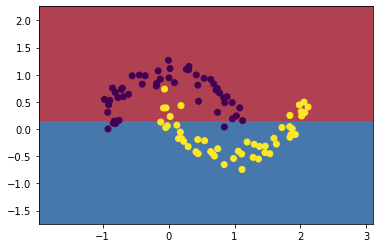

In [268]:
tree = Tree(1,1)
dic = tree.train(x, y)
def tree_clf(x):
    y_pred = list()  
    for it in x.transpose():
        # Алгоритм классификации
        y_pred.append(tree.predict(dic, it)) 
    return np.array(y_pred)


h = .02
x0_min, x0_max = np.min(x[:,0]) - 1, np.max(x[:,0]) + 1
x1_min, x1_max = np.min(x[:,1]) - 1, np.max(x[:,1]) + 1
xx0, xx1 = np.meshgrid(np.arange(x0_min, x0_max, h),
                         np.arange(x1_min, x1_max, h))

Z = tree_clf(np.stack((xx0.ravel(),xx1.ravel())))

Z = Z.reshape(xx0.shape)
cm = plt.cm.RdBu
plt.contourf(xx0, xx1, Z, cmap=cm, alpha=.8)
plt.scatter(x[:,0], x[:,1], c = y)


In [269]:
dic

{'num': 1, 'pk': 0.15660698194684816, 'left': 1, 'right': 0}

### Глубина 2

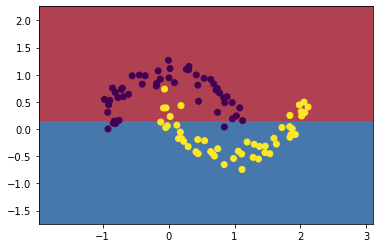

In [270]:
tree = Tree(2,1)
dic = tree.train(x, y)
def tree_clf(x):
    y_pred = list()  
    for it in x.transpose():
        # Алгоритм классификации
        y_pred.append(tree.predict(dic, it)) 
    return np.array(y_pred)


h = .02
x0_min, x0_max = np.min(x[:,0]) - 1, np.max(x[:,0]) + 1
x1_min, x1_max = np.min(x[:,1]) - 1, np.max(x[:,1]) + 1
xx0, xx1 = np.meshgrid(np.arange(x0_min, x0_max, h),
                         np.arange(x1_min, x1_max, h))

Z = tree_clf(np.stack((xx0.ravel(),xx1.ravel())))

Z = Z.reshape(xx0.shape)
cm = plt.cm.RdBu
plt.contourf(xx0, xx1, Z, cmap=cm, alpha=.8)
plt.scatter(x[:,0], x[:,1], c = y)

In [271]:
dic

{'num': 1,
 'pk': 0.15660698194684816,
 'left': {'num': 1, 'pk': -0.45366497041352327, 'left': 1, 'right': 1},
 'right': {'num': 1, 'pk': 0.15660698194684816, 'left': 0, 'right': 0}}

### Глубина 3

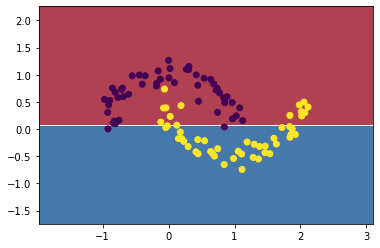

In [272]:
tree = Tree(3,1)
dic = tree.train(x, y)
def tree_clf(x):
    y_pred = list()  
    for it in x.transpose():
        # Алгоритм классификации
        y_pred.append(tree.predict(dic, it)) 
    return np.array(y_pred)


h = .02
x0_min, x0_max = np.min(x[:,0]) - 1, np.max(x[:,0]) + 1
x1_min, x1_max = np.min(x[:,1]) - 1, np.max(x[:,1]) + 1
xx0, xx1 = np.meshgrid(np.arange(x0_min, x0_max, h),
                         np.arange(x1_min, x1_max, h))

Z = tree_clf(np.stack((xx0.ravel(),xx1.ravel())))

Z = Z.reshape(xx0.shape)
cm = plt.cm.RdBu
plt.contourf(xx0, xx1, Z, cmap=cm, alpha=.8)
plt.scatter(x[:,0], x[:,1], c = y)

In [273]:
dic

{'num': 1,
 'pk': 0.15660698194684816,
 'left': {'num': 1,
  'pk': -0.45366497041352327,
  'left': {'num': 1, 'pk': -0.5211841698055503, 'left': 1, 'right': 1},
  'right': {'num': 1, 'pk': 0.060431370168558665, 'left': 1, 'right': 0}},
 'right': {'num': 1, 'pk': 0.15660698194684816, 'left': 0, 'right': 0}}